In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names, DatasetDict
from tqdm import tqdm

sns.set_color_codes("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("talk")
tqdm.pandas()

# set font to times new roman for plots
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

/Users/kyle/miniconda3/envs/memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

In [2]:
split_sample_size = None
label_title_padding = 10
study_pile = False
RECITATION_THRESHOLD = 10

In [3]:
memories_path = "usvsnsp/generation-semantic-filters"
intermediate_path = "usvsnsp/generation-semantic-intermediate-filters"
memories_dataset = DatasetDict()
pile_dataset = DatasetDict()
splits = [split for split in get_dataset_split_names(memories_path) if "deduped" in split] + get_dataset_split_names(intermediate_path)
# drop splits with "pile" in the name
# splits = [split for split in splits if "pile" not in split and "deduped" in split]
splits = [split for split in splits if "deduped" in split]
print(splits)

['pile_deduped_1.4b', 'memories_deduped_410m', 'memories_deduped_1.4b', 'memories_deduped_6.9b', 'memories_deduped_1b', 'pile_deduped_410m', 'pile_deduped_2.8b', 'pile_deduped_160m', 'memories_deduped_12b', 'pile_deduped_6.9b', 'pile_deduped_1b', 'memories_deduped_70m', 'memories_deduped_2.8b', 'pile_deduped_12b', 'memories_deduped_160m', 'pile_deduped_70m', 'memories_deduped_12b.43000', 'memories_deduped_12b.103000', 'memories_deduped_12b.83000', 'memories_deduped_12b.63000', 'memories_deduped_12b.123000', 'memories_deduped_12b.23000']


In [4]:
print("Loading datasets...")
print(f"Split sample size: {split_sample_size}")

for split in tqdm(splits):
    model = split.split("_")[-1]
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() else "Final"
    formatted_split_name = split.replace("memories_", "").replace("deduped_", "deduped.").replace("pile_", "")
    dataset_path = memories_path if checkpoint == "Final" else intermediate_path
    if "memories" in split:
        memories_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)
    else:
        pile_dataset[formatted_split_name] = load_dataset(dataset_path, split=f"{split}[:{split_sample_size}]" if split_sample_size else split)

display(memories_dataset)
display(pile_dataset)

Loading datasets...
Split sample size: None


100%|██████████| 22/22 [10:18<00:00, 28.10s/it]


DatasetDict({
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 811040
    })
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
    

DatasetDict({
    deduped.1.4b: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
        num_rows: 5000000
    })
    deduped.410m: Dataset({
        features: ['sequence_id', 'tokens', 'text', 'is_incrementing', 'is_repeating', 'sequence_duplicates', 'max_frequency', 'avg_frequency', 'min_frequency', 'median_frequency', 'p25_frequency', 'p75_frequency', 'frequencies', 'nl_scores', '0_8_snowclones', '0_9_snowclones', '0_8_templates', '0_9_templates', 'huffman_coding_length', 'memorization_score', 'index', 'loss', 'prompt_perplexity', 'generation_perplexity', 'sequence_perplexity'],
   

In [5]:
split_to_param_count = {
    "70m": 70000000,
    "160m": 160000000,
    "410m": 410000000,
    "1b": 1000000000,
    "1.4b": 1400000000,
    "2.8b": 2800000000,
    "6.9b": 6900000000,
    "12b": 12000000000,
}

In [24]:
def get_frame_from_split(dataset, split_name, is_memorized):
    current_frame = dataset[split].to_pandas()
    current_frame.drop(columns=columns_to_drop, inplace=True)
    checkpoint = int(split.split(".")[-1]) if split.split(".")[-1][1].isnumeric() and len(split.split(".")) != 2 else "Final"
    current_frame["Checkpoint"] = checkpoint
    model = split.split("deduped")[-1][1:] if checkpoint == "Final" else split.split(".")[-2]
    current_frame["Model"] = model
    current_frame["Param Count"] = split_to_param_count[current_frame["Model"].iloc[0]]
    current_frame["Deduped"] = "deduped" in split
    current_frame["Memorized"] = is_memorized
    return current_frame


columns_to_drop = ["frequencies", "tokens", "text"]
combined_dataframe = None
for split in tqdm(memories_dataset, desc="Loading Memories"):
    current_frame = get_frame_from_split(memories_dataset, split, True)
    if combined_dataframe is None:
        combined_dataframe = current_frame
    else:
        combined_dataframe = pd.concat([combined_dataframe, current_frame])

for split in tqdm(pile_dataset, desc="Loading Pile"):
    current_frame = get_frame_from_split(pile_dataset, split, False)
    combined_dataframe = pd.concat([combined_dataframe, current_frame])

combined_dataframe = combined_dataframe.sort_values("Param Count")
# display(combined_dataframe.shape)
# display(combined_dataframe.columns)
combined_dataframe

Loading Pile: 100%|██████████| 8/8 [02:02<00:00, 15.29s/it]


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized
4999999,146403638,False,False,1,10346382453,1.676912e+09,1462435,42754129.0,9112132,1728418100,...,146403638.0,3.712891,5.739519,9.374301,53.803978,Final,70m,70000000,True,False
1392363,28389141,False,False,1,11740996961,3.280973e+09,589316,237957196.5,5864365,4201626736,...,28389141.0,3.718750,12.002856,7.046402,84.576958,Final,70m,70000000,True,False
1392364,28390708,False,False,1,10346382453,2.100984e+09,708704,487321485.0,15526702,4084327341,...,28390708.0,3.669922,15.481421,7.782652,120.486526,Final,70m,70000000,True,False
1392365,28391631,False,False,1,11740996961,1.634204e+09,8442720,471247322.0,106137180,918861018,...,28391631.0,3.689453,2.313667,1.719604,3.978590,Final,70m,70000000,True,False
1392366,28402202,False,False,62,11740996961,1.877380e+09,942253,331265808.0,8759840,805411051,...,28402202.0,3.650391,1.934296,6.144555,11.885390,Final,70m,70000000,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273159,9069785,False,False,1,9362638615,4.804305e+08,441680,10474597.5,2093130,47941870,...,9069785.0,2.419922,4.043283,3.445634,13.931673,Final,12b,12000000000,True,False
2273160,9074394,False,False,2,10346382453,1.023979e+09,682554,62437106.5,4348851,252804149,...,9074394.0,2.500000,7.942500,2.781092,22.088825,Final,12b,12000000000,True,False
2273161,9075271,False,False,2,10346382453,1.945579e+09,513344,38436463.0,9082200,1188287314,...,9075271.0,2.611328,5.185763,4.454333,23.099115,Final,12b,12000000000,True,False
2273097,8861887,False,False,1,10346382453,1.749205e+09,513432,88625534.5,3168365,1879045405,...,8861887.0,2.490234,5.837689,4.160680,24.288754,Final,12b,12000000000,True,False


## Assign Examples to Taxonomy

In [44]:
def get_category(row):
    if row["Memorized"] == False:
        return "Not Memorized"
    if row["sequence_duplicates"] >= RECITATION_THRESHOLD:
        return "Recitation"
    if row["is_incrementing"] or row["is_repeating"]:
        return "Reconstruction"

    return "Recollection"

combined_dataframe["category"] = combined_dataframe.progress_apply(lambda row: get_category(row), axis=1)
combined_dataframe.value_counts(["Model", "Checkpoint", "category"])

100%|██████████| 53510441/53510441 [07:16<00:00, 122543.17it/s]


Model  Checkpoint  category      
1.4b   Final       Not Memorized     5000000
6.9b   Final       Not Memorized     5000000
1b     Final       Not Memorized     5000000
410m   Final       Not Memorized     5000000
160m   Final       Not Memorized     5000000
12b    Final       Not Memorized     5000000
2.8b   Final       Not Memorized     5000000
70m    Final       Not Memorized     5000000
12b    Final       Recitation        1521554
6.9b   Final       Recitation        1379503
12b    123000      Recitation        1271509
2.8b   Final       Recitation        1114324
12b    103000      Recitation         972908
1.4b   Final       Recitation         868737
1b     Final       Recitation         860603
12b    83000       Recitation         692617
410m   Final       Recitation         677656
160m   Final       Recitation         488998
12b    63000       Recitation         477775
70m    Final       Recitation         356982
12b    Final       Recollection       321445
       43000       Re

## Plot Graphs

## Figure: Perplexity and Duplication

In [45]:
combined_dataframe[(combined_dataframe["Model"] == "12b") & (combined_dataframe["Checkpoint"] == "Final") & (combined_dataframe["Deduped"] == True)][["Memorized", "generation_perplexity"]].groupby("Memorized").describe()

generation_perplexity                                          \
                          count      mean       std       min       25%   
Memorized                                                                 
False                 5000000.0  3.360266  1.640317  1.000001  2.257652   
True                  1871216.0  1.016462  0.027916  1.000001  1.001755   

                                          
                50%       75%        max  
Memorized                                 
False      3.147035  4.131655  79.729668  
True       1.008260  1.022215   4.549338

/var/folders/_m/m_v8tmqs05lf3_0frmhh2tkc0000gn/T/ipykernel_83211/612386107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deduped_12b["Distribution"] = deduped_12b["memorization_score"].apply(lambda x: "Memorized" if x == 1 else "Not Memorized")


,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized,category,Distribution
1870669,141069590,False,False,23,11740996961,3.062172e+09,385585,42147220.0,3731053,10346382453,...,2.078063,1.055097,2.192558,Final,12b,12000000000,True,True,Recitation,Memorized
1870665,141032373,False,False,1,11740996961,1.761649e+09,1537814,178678540.0,28498579,294872038,...,2.828423,1.038070,2.936101,Final,12b,12000000000,True,True,Recollection,Memorized
1870663,141003810,False,False,74,11740996961,9.927730e+08,1839695,213319733.0,87479721,695610999,...,1.943612,1.042965,2.027120,Final,12b,12000000000,True,True,Recitation,Memorized
1870660,140995027,False,False,8,10346382453,8.612123e+08,430843,95307051.5,20962725,395603541,...,1.572802,1.001615,1.575343,Final,12b,12000000000,True,True,Recollection,Memorized
1870656,140985458,False,False,2,11740996961,1.557942e+09,569047,9674012.5,2348248,252804149,...,1.537818,1.052602,1.618711,Final,12b,12000000000,True,True,Recollection,Memorized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273158,9068535,False,False,1,10346382453,1.373884e+09,547478,76865674.0,5087475,305529768,...,5.665259,3.630521,20.567841,Final,12b,12000000000,True,False,Not Memorized,Not Memorized
2273159,9069785,False,False,1,9362638615,4.804305e+08,441680,10474597.5,2093130,47941870,...,4.043283,3.445634,13.931673,Final,12b,12000000000,True,False,Not Memorized,Not Memorized
2273160,9074394,False,False,2,10346382453,1.023979e+09,682554,62437106.5,4348851,252804149,...,7.942500,2.781092,22.088825,Final,12b,12000000000,True,False,Not Memorized,Not Memorized
2273161,9075271,False,False,2,10346382453,1.945579e+09,513344,38436463.0,9082200,1188287314,...,5.185763,4.454333,23.099115,Final,12b,12000000000,True,False,Not Memorized,Not Memorized


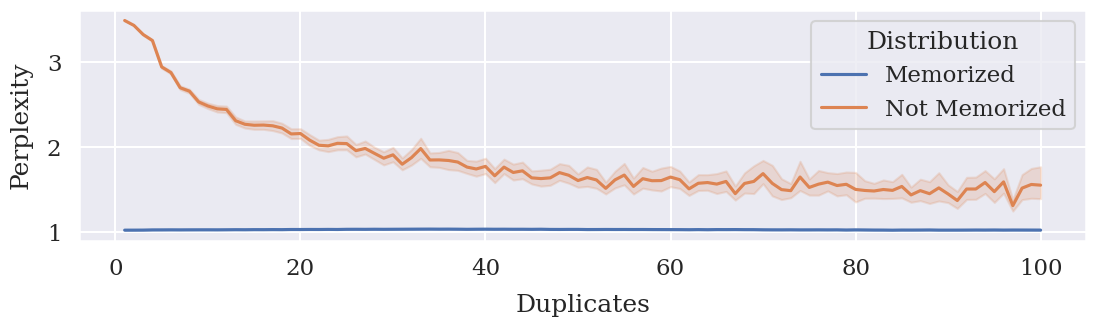

In [56]:
# line plot where sequence_duplicates is the x axis and the y axis is the generation_perplexity
deduped_12b = combined_dataframe[(combined_dataframe["Model"] == "12b") & (combined_dataframe["Checkpoint"] == "Final") & (combined_dataframe["Deduped"] == True)]
deduped_12b["Distribution"] = deduped_12b["memorization_score"].apply(lambda x: "Memorized" if x == 1 else "Not Memorized")
# deduped_12b = deduped_12b[deduped_12b["category"] != "Reconstruction"]
deduped_12b = deduped_12b[deduped_12b["sequence_duplicates"] <= 100]

display(deduped_12b)

# Plot lineplot
sns.lineplot(data=deduped_12b, x="sequence_duplicates", y="generation_perplexity", hue="Distribution")

# y label is "Perplexity" and x label is "Duplicates"
plt.xlabel("Duplicates", labelpad=label_title_padding)
plt.ylabel("Perplexity", labelpad=label_title_padding)

# set figure dimensions
plt.gcf().set_size_inches(13, 3)

# log x axis
# plt.xscale("log")

In [57]:
# deduped_12b where memorization_scorem == 1 and Memorized = True
memorized_False = len(deduped_12b[(deduped_12b["Memorized"] == False)])
false_with_score_1 = len(deduped_12b[(deduped_12b["Memorized"] == False) & (deduped_12b["memorization_score"] == 1)])
print(f"False with score 1: {false_with_score_1} / {memorized_False} = {100 * false_with_score_1 / memorized_False}")

False with score 1: 21837 / 4944218 = 0.441667418386487


In [59]:
# get mean and std dev for each bucket
duplication_ppl_stats = deduped_12b.groupby(["sequence_duplicates", "Distribution"]).agg({"generation_perplexity": ["mean", "std"]})
# display the entire frame

display(duplication_ppl_stats)
duplication_ppl_stats.to_csv("duplication_ppl_stats.csv")

generation_perplexity          
                                                   mean       std
sequence_duplicates Distribution                                 
1                   Memorized                  1.025088  0.024192
                    Not Memorized              3.487610  1.632850
2                   Memorized                  1.025366  0.024381
                    Not Memorized              3.430138  1.599781
3                   Memorized                  1.026001  0.024695
...                                                 ...       ...
98                  Not Memorized              1.518876  0.910923
99                  Memorized                  1.026345  0.023613
                    Not Memorized              1.561753  1.010581
100                 Memorized                  1.025969  0.023422
                    Not Memorized              1.553552  1.219477

[200 rows x 2 columns]

In [36]:
combined_memories_dataframe = combined_dataframe[combined_dataframe["Memorized"] == True]
combined_memories_dataframe

,sequence_id,is_incrementing,is_repeating,sequence_duplicates,max_frequency,avg_frequency,min_frequency,median_frequency,p25_frequency,p75_frequency,...,index,loss,prompt_perplexity,generation_perplexity,sequence_perplexity,Checkpoint,Model,Param Count,Deduped,Memorized
45052,34298212,False,False,426,11740996961,2.487787e+09,485893,133823721.5,5312777,1659997854,...,34298212.0,0.837402,8.775765,1.120832,9.836162,Final,70m,70000000,True,True
45051,34268423,False,False,4290875,11740996961,9.905874e+08,4604792,135808597.0,33268754,553893182,...,34268423.0,0.916016,1.607914,1.000117,1.608103,Final,70m,70000000,True,True
45050,34198340,False,False,610563,11740996961,2.698931e+09,1651253,30200063.5,6123993,4201626736,...,34198340.0,0.834473,1.247754,1.000919,1.248901,Final,70m,70000000,True,True
45049,34171521,False,False,35808,11740996961,1.393041e+09,816502,90346177.0,8576194,774995614,...,34171521.0,0.854004,2.283500,1.018759,2.326336,Final,70m,70000000,True,True
45048,34153550,False,False,3219,11740996961,1.924204e+09,3982948,146683835.5,16400100,918861018,...,34153550.0,0.849121,1.839969,1.005253,1.849635,Final,70m,70000000,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019319,124187108,False,False,7,11740996961,1.944991e+09,504109,380609897.5,11268951,816247750,...,124187108.0,0.500488,1.415019,1.025460,1.451046,Final,12b,12000000000,True,True
1019320,124191334,False,False,4290720,11740996961,6.408026e+08,4604792,135808597.0,33268754,553893182,...,124191334.0,0.725098,2.861616,1.000002,2.861621,Final,12b,12000000000,True,True
1019321,124191419,False,False,8431,11740996961,1.703002e+09,774883,22749587.5,3949410,651837679,...,124191419.0,0.685547,1.576193,1.000897,1.577607,Final,12b,12000000000,True,True
1019257,123520680,False,False,8992,11740996961,9.859169e+08,739767,51408803.5,8618633,451704338,...,123520680.0,0.548828,1.238416,1.000352,1.238852,Final,12b,12000000000,True,True


### Figure: Count and Memories by Taxonomy Across Time and Scale

In [38]:
# Create plot for data across 
final_checkpoint_counts_frame = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == "Final"].value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
final_checkpoint_counts_frame.to_csv(f"final_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(final_checkpoint_counts_frame)

intermediate_frame = combined_memories_dataframe[(combined_memories_dataframe["Checkpoint"] != "Final") & (combined_memories_dataframe["Model"] == "12b")]
sorted_checkpoints = sorted(intermediate_frame["Checkpoint"].unique(), key=lambda x: int(x))

intermediate_checkpoint_counts_frame = intermediate_frame.value_counts(["Checkpoint", "category"]).unstack().reindex(sorted_checkpoints)
intermediate_checkpoint_counts_frame.to_csv(f"intermediate_checkpoint_counts_recitation={RECITATION_THRESHOLD}.csv")
display(intermediate_checkpoint_counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,356982,38351,16115
160000000,488998,70805,21397
410000000,677656,109520,23864
1000000000,860603,147248,25021
1400000000,868737,154990,24377
2800000000,1114324,214053,26839
6900000000,1379503,273262,27531
12000000000,1521554,321445,28217


category,Recitation,Recollection,Reconstruction
Checkpoint,,,
23000,134747,24659,4012
43000,294235,57131,7497
63000,477775,95574,11718
83000,692617,143741,15710
103000,972908,202754,19916
123000,1271509,268342,24204


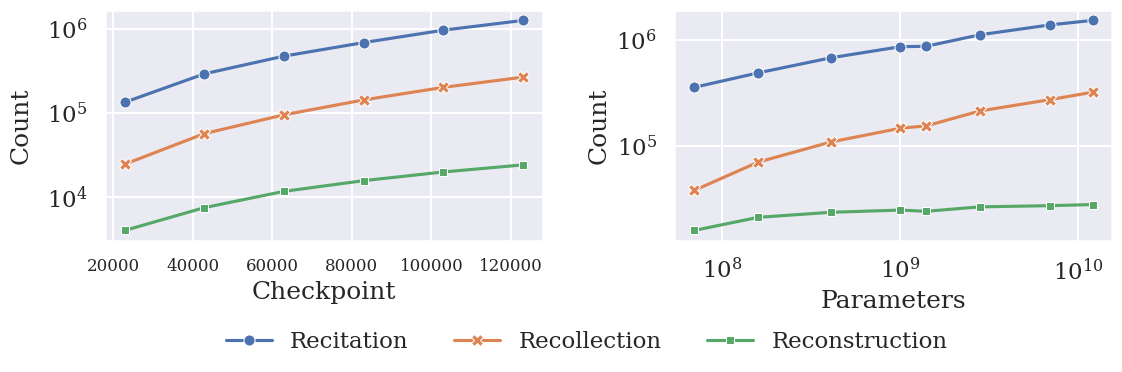

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))

# set figure 1
# first figure is a line plot of the counts of each category for across intermediate checkpoints

sns.lineplot(ax=axes[0], data=intermediate_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# rotate x axis labels
# axes[0].tick_params(axis='x', rotation=20)

# make x labels smaller
axes[0].tick_params(axis='x', labelsize=12)

# Add y label for Count
axes[0].set_ylabel("Count", labelpad=label_title_padding)

# add padding for labels
fig.subplots_adjust(wspace=0.2)

# make x and y axis log scale
axes[0].set_yscale("log")

# # have a common legend for both plots centered below the figure. No legend box
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.3), ncol=4, frameon=False)

# set figure 2
# the second figure is a line plot of the counts of each category across parameter count

sns.lineplot(ax=axes[1], data=final_checkpoint_counts_frame, dashes=False, markers=True, markersize=8)

# make x and y axis log scale
axes[1].set_xscale("log")
axes[1].set_yscale("log")

# Set x label to "Parameters"
axes[1].set_xlabel("Parameters")

# Add y label for Count
axes[1].set_ylabel("Count")

# remove legend
axes[1].legend().remove()

# add padding for labels
fig.subplots_adjust(wspace=0.30)

fig.savefig(f"categories_counts_across_time+scale_recitation={RECITATION_THRESHOLD}.png", bbox_inches="tight")



### Figure: Percents and Memories by Taxonomy Across Time and Scale

In [40]:
counts_frame = combined_memories_dataframe.value_counts(["Param Count", "category"]).unstack().reindex(split_to_param_count.values())
display(counts_frame)

category,Recitation,Recollection,Reconstruction
Param Count,,,
70000000,356982,38351,16115
160000000,488998,70805,21397
410000000,677656,109520,23864
1000000000,860603,147248,25021
1400000000,868737,154990,24377
2800000000,1114324,214053,26839
6900000000,1379503,273262,27531
12000000000,5365345,1113646,111274


In [41]:
sorted_checkpoints = [23000, 43000, 63000, 83000, 103000, 123000]
assert len(sorted_checkpoints) + 1 == len(combined_memories_dataframe[(combined_memories_dataframe["Model"] == "12b") & (combined_memories_dataframe["Deduped"] == True)]["Checkpoint"].unique())

all_percents_time = []
for checkpoint in tqdm(sorted_checkpoints):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Checkpoint"] == checkpoint]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_time.append({
            "Checkpoint": checkpoint,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_time = pd.DataFrame(all_percents_time).pivot(index="Checkpoint", columns="category", values="percent").reindex(sorted_checkpoints)
percents_frame_time.to_csv(f"percents_frame_time_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_time)

100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


category,Recitation,Recollection,Reconstruction
Checkpoint,,,
23000,0.824554,0.150895,0.024551
43000,0.819909,0.159200,0.020891
63000,0.816616,0.163356,0.020028
83000,0.812866,0.168697,0.018437
103000,0.813755,0.169587,0.016658
123000,0.812957,0.171568,0.015475


In [42]:
all_percents_scale = []
for param_count in tqdm(split_to_param_count.values()):
    model_examples = combined_memories_dataframe[combined_memories_dataframe["Param Count"] == param_count]
    model_percents = model_examples.value_counts("category", normalize=True).to_dict()
    for category in model_percents:
        all_percents_scale.append({
            "Model": model_examples["Model"].unique()[0],
            "Param Count": param_count,
            "category": category,
            "percent": model_percents[category],
        })

percents_frame_scale = pd.DataFrame(all_percents_scale).pivot(index="Model", columns="category", values="percent").reindex(split_to_param_count.keys())
percents_frame_scale.to_csv(f"percents_frame_scale_recitation={RECITATION_THRESHOLD}.csv")
display(percents_frame_scale)

100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


category,Recitation,Recollection,Reconstruction
Model,,,
70m,0.867624,0.093210,0.039167
160m,0.841359,0.121826,0.036815
410m,0.835540,0.135036,0.029424
1b,0.833214,0.142562,0.024225
1.4b,0.828865,0.147877,0.023258
2.8b,0.822248,0.157948,0.019804
6.9b,0.820988,0.162627,0.016385
12b,0.814132,0.168983,0.016885


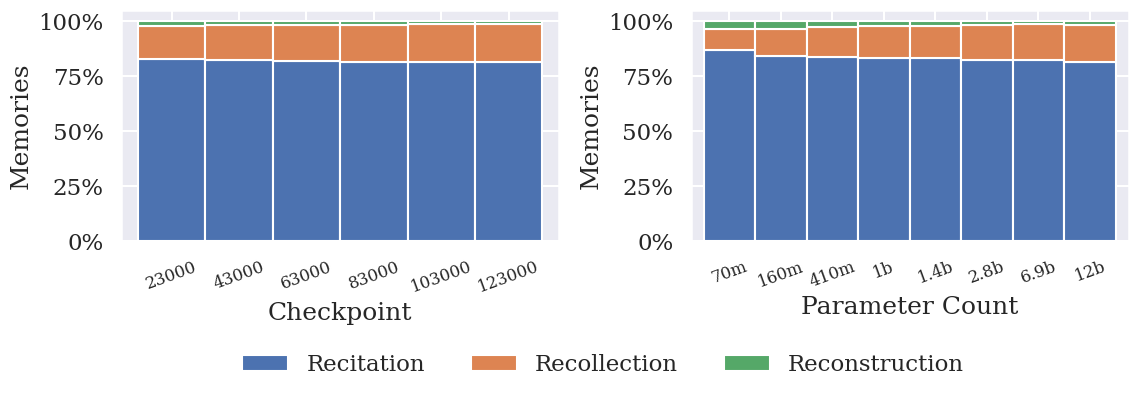

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(13, 3))
plots = [
    (percents_frame_time, axes[0]),
    (percents_frame_scale, axes[1])
]

for idx, (data, ax) in enumerate(plots):
    data.plot.bar(
        stacked=True,
        ax=ax,
        rot=0,
        width=1,
        ylabel="Memories",
    )

    if idx == 0:
        ax.set_xlabel("Checkpoint")
    else:
        ax.set_xlabel("Parameter Count")
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}%".format(int(x * 100))))
    ax.tick_params(axis='x', rotation=20, labelsize=12)
    ax.get_legend().remove()

# Adjusting subplot parameters
fig.subplots_adjust(wspace=0.30)

# Common legend configuration
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.4), ncol=4, frameon=False)

# Save the figure
fig.savefig(f"categories_percents_across_time+scale_recitation={RECITATION_THRESHOLD}.png", bbox_inches="tight")
